In [30]:
%matplotlib inline
import torch
import math
import torchvision
from torchvision import datasets, models
from torchvision.transforms import ToTensor,Lambda
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from tempfile import TemporaryDirectory
import os
import numpy as np
import torch.nn.functional as F


# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())
device = torch.device("mps")
print(device)
print()

torch.manual_seed(17)


True
True
mps



In [31]:
number_of_classes = 4
labels_map = {
    0: "Angry",
    1: "Other",
    2: "Sad",
    3: "Happy",
}

# Calculated in advanced based on training data
mean = torch.tensor([0.5001, 0.4557, 0.4074])
std = torch.tensor([0.2789, 0.2679, 0.2712])

Data loader creation

In [32]:
# Resize images, first we cheacked wether all images are of same size or not
# output vector to one hot encoding
input_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
    ])
target_transform=Lambda(lambda y: torch.zeros(number_of_classes, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

In [33]:
training_data = datasets.ImageFolder(root = "data/Animal_emotions/master_folder/train", transform=input_transform,target_transform = target_transform)
val_data = datasets.ImageFolder(root = "data/Animal_emotions/master_folder/valid", transform=input_transform,target_transform = target_transform)
test_data = datasets.ImageFolder(root = "data/Animal_emotions/master_folder/test", transform=input_transform)

In [34]:
# print(training_data.class_to_idx)
# print(test_data.class_to_idx)
# print(val_data.class_to_idx)

In [35]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [36]:
dataset_sizes = {"train" : len(training_data), "val" : len(val_data)}
dataloaders =  {"train": train_dataloader, "val" : val_dataloader, "test" : test_dataloader}

In [37]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

In [38]:
print(images.shape,labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 4])


In [39]:
img_grid = torchvision.utils.make_grid(images) # making image grid

In [40]:
img_grid.shape

torch.Size([3, 906, 1810])

Tensorboard setting

In [60]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/animal_emotions_loss_graph_v4')

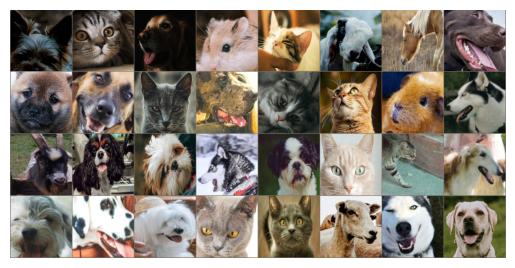

In [61]:
def matplotlib_imshow(inp,title=None):
    """Display image for Tensor."""
#     print(inp.shape)
    inp = inp.numpy().transpose((1, 2, 0))
    mean1 = np.array(mean)
    std1 = np.array(std)
    inp = std1 * inp + mean1
    inp = np.clip(inp, 0, 1)
#     print(inp.shape)
#     npimg = inp.numpy()
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

matplotlib_imshow(img_grid)
writer.add_image('Animal_emotions_images', img_grid)

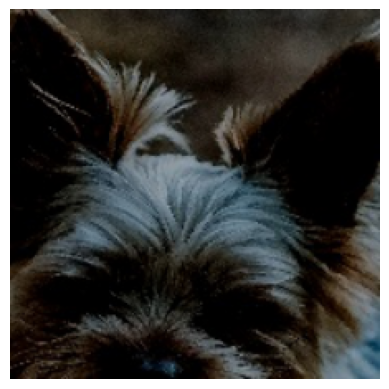

In [62]:
matplotlib_imshow(images[0])

In [63]:
images[0].shape

torch.Size([3, 224, 224])

Defining Model parameters

In [64]:
model= models.resnet18(weights=models.ResNet18_Weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, number_of_classes)



In [65]:
model = model.to("cpu")
writer.add_graph(model, images)
writer.close()

In [66]:
model = model.to(device)

In [67]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [68]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
#     model = model.to("cpu")
#     images = images.to("cpu")
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    images = images.to("cpu")
    labels = labels.to("cpu")
    net = net.to("cpu")
#     print("images.shape = ",images.shape)
#     print("labels.shape = ",images.shape)
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(20, 40))
    for idx in range(batch_size):
        ax = fig.add_subplot(8,4 , idx+1, xticks=[], yticks=[])
#         print(images[idx].shape)
        inp = images[idx].cpu().numpy().transpose((1, 2, 0))
        mean1 = np.array(mean)
        std1 = np.array(std)
        inp = std1 * inp + mean1
        inp = np.clip(inp, 0, 1)
        ax.imshow(inp)
        ax.axis('off')
#         matplotlib_imshow(images[idx])
#         print(preds[idx],labels[idx],torch.argmax(labels[idx]).item())
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            labels_map[preds[idx].item()],
#             labels_map[preds[idx]],
            probs[idx] * 100.0,
            labels_map[torch.argmax(labels[idx]).item()]),
                    color=("green" if preds[idx].item()==torch.argmax(labels[idx]).item() else "red"))
    return fig

# labels_map[preds[j].cpu().item()

In [69]:
import tensorflow as tf

In [70]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [71]:
# len(dataloaders["train"])//batch_size

Define training loop

In [72]:
def training_loop(model,criterion,optimizer,exp_lr_scheduler, epochs = 3):
    since = time.time()
########## Code for saving the best Model  ##########         
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
##########
    
    
        for epoch in range(epochs):
            model = model.to(device)
            print(f'Epoch {epoch}/{epochs - 1}')
            print('-' * 10)
            
            # Training phase
            phase = "train"
            model.train()
            
            running_loss = 0.0   # Total loss of a batch, i.e. we multiply by batch size
            running_corrects = 0 # Total correct out of prediction
            im_counts = 0
            for i, (images, labels) in enumerate(dataloaders["train"]):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs,labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()*images.size(0)
                im_counts = im_counts + images.size(0)
                if i%10 == 9:
                    writer.add_scalars('Loss',{'Training': running_loss/im_counts},(epoch*len(training_data))//batch_size + i)
                    writer.add_figure('prediction vs actual', plot_classes_preds(model,images,labels), \
                                              global_step=epoch*(len(dataloaders[phase])) + i)
                

                    
                model = model.to(device)
                predicted = torch.sigmoid(outputs) >= 0.5
                running_corrects += (predicted == labels).all(1).sum().item()
                
                
            exp_lr_scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            writer.add_scalars('Accuracy',{'Training': epoch_acc},epoch)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
#             --------------------- Traing Phase Fininshed -------------------

#           validation Phase

            model = model.to(device)
            model.eval()
            phase = "val"
            
            running_loss = 0.0   # Total loss of a batch, i.e. we multiply by batch size
            running_corrects = 0 # Total correct out of prediction
            val_imgs = 0
            for i, (images, labels) in enumerate(dataloaders[phase]):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs,labels)
                running_loss += loss.item()*images.size(0)

                predicted = torch.sigmoid(outputs) >= 0.5
                running_corrects += (predicted == labels).all(1).sum().item()
            
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            writer.add_scalars('Loss',{'Validation': epoch_loss},(epoch*len(training_data))//batch_size)
            writer.add_scalars('Accuracy',{'Validation': epoch_acc},epoch)    
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
            
            best_acc = epoch_acc
            torch.save(model.state_dict(), best_model_params_path)
            
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
            
    return model
                

In [73]:
model = training_loop(model,criterion,optimizer,exp_lr_scheduler, epochs = 50)

Epoch 0/49
----------
train Loss: 0.5954 Acc: 0.0320
val Loss: 0.5615 Acc: 0.0278
Epoch 1/49
----------
train Loss: 0.5121 Acc: 0.0570
val Loss: 0.5396 Acc: 0.0278
Epoch 2/49
----------
train Loss: 0.4674 Acc: 0.1470
val Loss: 0.5373 Acc: 0.1389
Epoch 3/49
----------
train Loss: 0.4313 Acc: 0.2280
val Loss: 0.5251 Acc: 0.1389
Epoch 4/49
----------
train Loss: 0.4037 Acc: 0.3020
val Loss: 0.5143 Acc: 0.1667
Epoch 5/49
----------
train Loss: 0.3751 Acc: 0.3810
val Loss: 0.5150 Acc: 0.2222
Epoch 6/49
----------
train Loss: 0.3474 Acc: 0.4310
val Loss: 0.5054 Acc: 0.2500
Epoch 7/49
----------
train Loss: 0.3309 Acc: 0.5100
val Loss: 0.5129 Acc: 0.2222
Epoch 8/49
----------
train Loss: 0.3284 Acc: 0.5050
val Loss: 0.5135 Acc: 0.2222
Epoch 9/49
----------
train Loss: 0.3248 Acc: 0.5110
val Loss: 0.5141 Acc: 0.2222
Epoch 10/49
----------
train Loss: 0.3197 Acc: 0.5160
val Loss: 0.5176 Acc: 0.2500
Epoch 11/49
----------
train Loss: 0.3201 Acc: 0.5160
val Loss: 0.5057 Acc: 0.2778
Epoch 12/49
--

In [74]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean1 = np.array(mean)
    std1 = np.array(std)
    inp = std1 * inp + mean1
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds)
            print(preds[0].cpu().item())

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {labels_map[preds[j].cpu().item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([3, 1, 2, 2, 0, 1, 0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 0, 2, 2, 0, 3, 0, 2, 3,
        0, 1, 1, 0, 1, 3, 3, 3], device='mps:0')
3


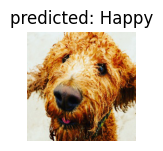

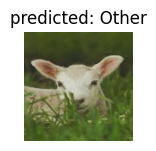

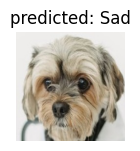

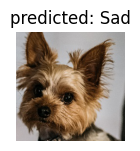

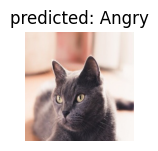

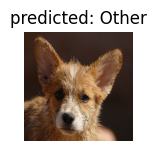

In [75]:
visualize_model(model)